In [1]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

In [119]:
print("OpenCV version:", cv2.__version__)
print("imutils version:", imutils.__version__)

OpenCV version: 4.10.0
imutils version: 0.5.4


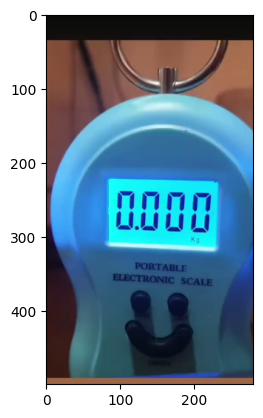

In [120]:
vidcap = cv2.VideoCapture("dyn_video5.mp4")
totalFrames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
randomFrameNumber = random.randint(0, int(totalFrames))
vidcap.set(cv2.CAP_PROP_POS_FRAMES,0)
success, image = vidcap.read()
if success:
    img = imutils.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), height=500)
plt.imshow(img)

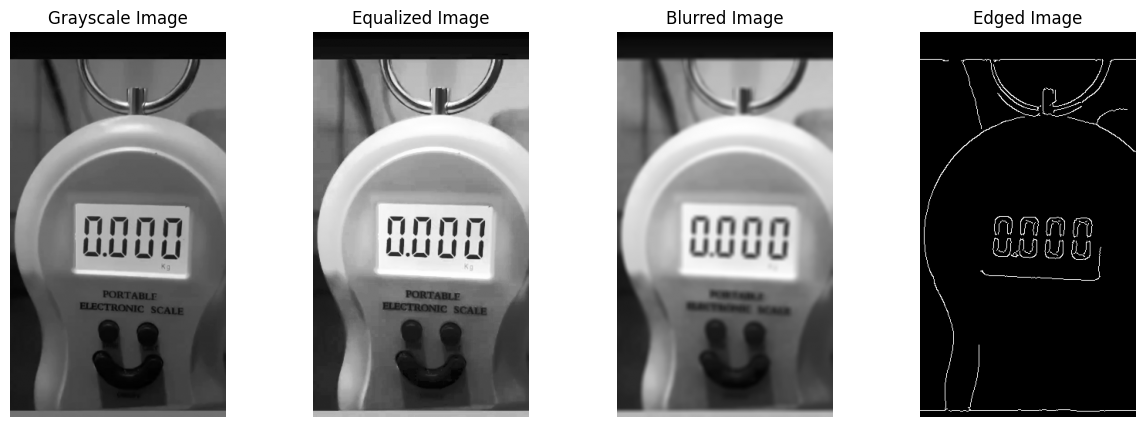

In [121]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
eq = cv2.equalizeHist(gray)
blurred = cv2.GaussianBlur(eq, (7,7), 3)
edged = cv2.Canny(blurred, 50, 150, 255)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(gray, cmap='gray')
axs[0].set_title('Grayscale Image')
axs[1].imshow(eq, cmap='gray')
axs[1].set_title('Equalized Image')
axs[2].imshow(blurred, cmap='gray')
axs[2].set_title('Blurred Image')
axs[3].imshow(edged, cmap='gray')
axs[3].set_title('Edged Image')
for ax in axs:
    ax.axis('off')
plt.show()
# plt.imshow(edged)

In [111]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [112]:
image_with_contours = img.copy()

# Draw all contours on the image
for i, c in enumerate(cnts):
    color = (0, 255, 0)  # Green color for contours
    thickness = 1        # Thickness of the contour lines

    # Draw the contour
    cv2.drawContours(image_with_contours, [c], -1, color, thickness)

    # Draw the contour index and points for visualization
    for j, point in enumerate(c):
        x, y = point[0]
        cv2.circle(image_with_contours, (x, y), 2, (255, 0, 0), -1)  # Blue circles for points

# Show the image with contours
cv2.imshow("Contours", image_with_contours)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [113]:
LCDbox = None

for c in cnts:
    temp_image = img.copy()
    rect = cv2.minAreaRect(c)
    (center_x, center_y), (width, height), angle = rect
    print(f"Center: {(center_x, center_y)}, dims: {(width, height)}, angle: {angle}")
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    # draw contour
    # color = (255, 0, 0)
    # thickness = 1
    # cv2.drawContours(temp_image, [c], -1, color, thickness)
    # for j, point in enumerate(c):
    #     x, y = point[0]
    #     cv2.circle(temp_image, (x, y), 2, (0, 0, 0), -1)
    
    # cv2.drawContours(temp_image, [box], -1, (0, 255, 0), 2)
    # cv2.imshow("Contours", temp_image)

    rect_area = rect[1][0] * rect[1][1]

    # Compare the areas
    if rect_area > 14000:
        if (100 < center_x < 160 and 270 < center_y < 300) and (150 < width < 155 and 90 < height < 100) :
            print("Screen found.\n")
            LCDbox = box
            break
        else:
            print("The contour is not a rectangle.\n")
            
if LCDbox is None:
    print("Screen not found")

    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

Center: (153.0, 306.0), dims: (20.0, 6.0), angle: 90.0
Center: (154.49505615234375, 281.04949951171875), dims: (6.1692304611206055, 18.308683395385742), angle: 5.710593223571777
Center: (77.47715759277344, 88.8975601196289), dims: (117.20205688476562, 30.829425811767578), angle: 57.45000076293945
Center: (248.37086486816406, 203.3978271484375), dims: (116.31475830078125, 13.247611999511719), angle: 55.336551666259766
Center: (169.54678344726562, 106.38534545898438), dims: (43.94489669799805, 101.16456604003906), angle: 61.27967071533203
Center: (49.674686431884766, 162.93963623046875), dims: (12.957658767700195, 118.84864807128906), angle: 59.11892318725586
Center: (188.28463745117188, 94.23649597167969), dims: (28.542573928833008, 117.61376953125), angle: 37.74681091308594
Center: (93.5, 315.0), dims: (6.0, 5.0), angle: 90.0
Center: (87.58934783935547, 97.21186065673828), dims: (89.372314453125, 20.105953216552734), angle: 50.029075622558594
Center: (113.84616088867188, 292.2692260742

In [114]:
def reorder_box_points(box):
    box = sorted(box, key=lambda p: (p[1], p[0]))  # Sort by y, then by x
    top_two = sorted(box[:2], key=lambda p: p[0])  # Sort top points by x
    bottom_two = sorted(box[2:], key=lambda p: p[0])  # Sort bottom points by x
    return np.array([top_two[0], top_two[1], bottom_two[1], bottom_two[0]], dtype=np.float32)

In [115]:
sorted_box = reorder_box_points(LCDbox)
print("Reordered box points:\n", sorted_box)

Reordered box points:
 [[ 53. 248.]
 [206. 253.]
 [203. 348.]
 [ 49. 342.]]


In [116]:
width = int(np.linalg.norm(sorted_box[0] - sorted_box[1]))
height = int(np.linalg.norm(sorted_box[0] - sorted_box[3]))

dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=np.float32)

M = cv2.getPerspectiveTransform(sorted_box, dst)

cropped = imutils.resize(cv2.warpPerspective(gray, M, (width, height)), height=145)

cv2.imshow('Cropped Box', cropped)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
DIGITS_PATTERNS = {
    (1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 0, 1): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

In [6]:
def find_most_similar(on_pattern):
    min_distance = float('inf')
    best_match = None

    for pattern, digit in DIGITS_PATTERNS.items():
        # Calculate Hamming distance
        distance = sum(a != b for a, b in zip(on_pattern, pattern))
        
        # Update best match if this pattern is more similar
        if distance < min_distance:
            min_distance = distance
            best_match = digit
    return best_match

In [9]:
print(find_most_similar((1, 0, 1, 1, 1, 0, 0)))

2


In [20]:
b = [[ 80., 225.],
     [238., 231.],
     [235., 328.],
     [ 77., 323.]]

scale = 1.1
center = np.mean(b, axis=0)  # Compute the center of the box
enlarged_roi_box = [
    tuple((point - center) * scale + center) for point in b
]
prev_roi_box = np.array([(float(x), float(y)) for x, y in enlarged_roi_box], dtype=np.float16)

In [21]:
prev_roi_box

array([[ 72.25, 219.9 ],
       [246.  , 226.4 ],
       [242.8 , 333.  ],
       [ 68.94, 327.5 ]], dtype=float16)